## Simple Genetic Algorithm
### María Carmen Aguirre Delgado

#### The algorithm is a type of evolutionary algorithm and performs an optimization procedure inspired by the biological theory of evolution by means of natural selection with a binary representation and simple operators based on genetic recombination and genetic mutations.

#### The algorithm uses analogs of a genetic representation (bitstrings), fitness (function evaluations), genetic recombination (crossover of bitstrings), and mutation (flipping bits).

# library

In [ ]:
# bibliotecas
import numpy as np
from numpy.random import randint
from numpy.random import rand
# using scikit-learn's MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import itertools
import math
import matplotlib.pyplot as plt

# import the necessary libraries
import seaborn as sns
import pandas as pd

# Code and decode

In [ ]:
# decode bitstring to numbers
# The decode() function below implements substring to an integer, taking the bounds of
# the function to be evluated, the number of bits per variable, and a bitstring as input and returns a
# list of decoded real values.
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        # store
        decoded.append(value)
    return decoded

In [ ]:
# Create a population of length n with chromosomes of lenght n_bits
def createPopulation(n, n_bits):
  pop = [np.random.randint(0, 2, n_bits).tolist() for i in range(n)]
  return pop

# Selection methods

## Selección por torneo
### La idea principal de este método consiste en realizar la selección en base a comparaciones directas entre individuos.

Se selecciona al azar un número k de individuos (generalmente se escoge $ k=2$). De entre los individuos seleccionados se selecciona el más apto para pasarlo a la siguiente generación.

La versión probabilística únicamente se diferencia en el paso de selección del ganador del torneo. En vez de escoger siempre el mejor se genera un número aleatorio del intervalo [0..1], si es mayor que un parámetro p (fijado para todo el proceso evolutivo) se escoge el individuo más alto y en caso contrario el menos apto. Generalmente p toma valores en el rango $ 0.5 < p \leq 1$.


In [ ]:
# tournament selection
def selection_tournament(population, fitness, k=2):
    # first random selection
    selection_ix = np.random.randint(len(population))
    for ix in np.random.randint(0, len(population), k):
        # check if better with k aleatory selections
        if fitness[ix] < fitness[selection_ix]:
            selection_ix = ix
    return population[selection_ix]

## Selección por ruleta

A cada uno de los individuos de la población se le asigna una parte proporcional a su ajuste de una ruleta, de tal forma que la suma de todos los porcentajes sea la unidad. Los mejores individuos recibirán una porción de la ruleta mayor que la recibida por los peores. Para seleccionar un individuo basta con generar un número aleatorio del intervalo [0..1] y devolver el individuo situado en esa posición de la ruleta.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

def selection_wheel(population, fitness):
    # Computes the totallity of the population fitness
    scaled = scaler.fit_transform([[x] for x in fitness])
    regular_list = scaled.tolist()
    fitness2 = list(itertools.chain(*regular_list))

    max = sum(fitness2)

    ## Computes for each chromosome the probability
    selection_probs = [fit/max for fit in fitness2]
    # Selects one chromosome based on the computed probabilities
    return population[np.random.choice(len(population), p = selection_probs)]

# Cruza en un punto

Una vez seleccionados los individuos, éstos son recombinados para producir la descendencia que se insertará en la siguiente generación. El cruce es una estrategia de reproducción sexual.

Su importancia para la transición entre generaciones es elevada puesto que las tasas de cruce con las que se suele trabajar rondan el 90%.

In [ ]:
# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	if rand() < r_cross:
		# select crossover a random point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

# Mutación aleatoria


La mutación de un individuo provoca que alguno de sus genes, generalmente uno sólo, varíe su valor de forma aleatoria.

Primeramente se seleccionan dos individuos de la población para realizar el cruce. Si el cruce tiene éxito entonces uno de los descendientes, o ambos, se muta con cierta probabilidad P. Se imita de esta manera el comportamiento que se da en la naturaleza, pues cuando se genera la descendencia siempre se produce algún tipo de error, por lo general sin mayor trascendencia, en el paso de la carga genética de padres a hijos.

La probabilidad de mutación es muy baja, generalmente menor al 1%. Esto se debe sobre todo a que los individuos suelen tener un fitness menor después de mutados. Sin embargo se realizan mutaciones para garantizar que ningún punto del espacio de búsqueda tenga una probabilidad nula de ser examinado.

La mutación más usual es el reemplazo aleatorio. Este consiste en variar aleatoriamente un gen de un cromosoma. Si se trabaja con codificaciones binarias consistirá simplemente en negar un bit.

In [ ]:
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

# Funciones de optimización de un solo objetivo para minimización

In [ ]:
def rastrigin(X, A = 10.0):
    delta = [x**2 - A * np.cos(2 * np.pi * x) for x in X]
    y = len(X)*A + sum(delta)
     #A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])
    return y

def beale(X):
    x, y = X[0], X[1]
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def eggholder(X):
	# X is a np.array
	return -(X[1] + 47) * np.sin(np.sqrt(abs(X[0]/2 + (X[1] + 47)))) -X[0] * np.sin(np.sqrt(abs(X[0] - (X[1] + 47))))


#Probar distintas estrategias de elitismo con la función de Eggholder.

Estrategias de elitismo:
  - Sin elitismo
  - Elitismo del mejor individuo
  - Elitismo de porcentaje: Se sustituye un porcentaje de los mejores individuos. Puede ser el 10 por ciento.
  - Elitismo total: Se usan ambas poblaciones, la población parental y la población hija y se selecciona a los n mejor individuos, donde n es el tamaño de la población.


In [ ]:
def elitism(population, population_childs, fitness, fitness_childs, method, percentage_to_replace = 0.1):
  n = len(population)
  if(method == 'total'):
    "combine the total population: childs and parents, mix and then select the best"
    pop_total = population + population_childs
    fit_total = fitness + fitness_childs
    fitness_sort, population_sort = zip(*sorted(zip(fit_total, pop_total), reverse =  False))
    fitness_sort, population_sort  = list(fitness_sort), list(population_sort)
    return population_sort[0:n]
  if(method == 'individual'):
    "Select the best and pass direct to the next generation, replace aleatory "
    best_id = fitness.index(min(fitness))
    best = population[best_id]
    to_replace = randint(n)
    population_childs[to_replace] = best
    return population_childs
  if(method == 'percentage'):
    "Select a percentage of the best an replace in the new generation aleatory"
    stop = math.ceil(n*percentage_to_replace)
    fitness_sort, population_sort = zip(*sorted(zip(fitness, population)))
    fitness_sort, population_sort  = list(fitness_sort), list(population_sort)
    i = 0
    for ix in np.random.randint(0, n, stop):
        population_childs[ix] = population_sort[i]
        ++i
    return population_childs
  if(method == 'None'):
    return population_childs

# Genetic algorithm with (or not) Elitism implementation

In [ ]:
def genetic_algorithm(objectiveFunction, bounds, n_bits, n_iter, n_pop, r_cross, r_mut, selectionMethod, method_elitism):
    # initial population of random bitstring
    pop = createPopulation(n_pop, n_bits*len(bounds))
    # initilizing the evaluation
    best, best_eval = 0, objectiveFunction(decode(bounds, n_bits, pop[0]))
    # enumerate generations
    for gen in range(n_iter):
        # decode population
        decoded = [decode(bounds, n_bits, chromosome) for chromosome in pop]
        # evaluate all candidates in the population
        fitness = [objectiveFunction(d) for d in decoded]
        # check for new best solution
        for i in range(n_pop):
            if fitness[i] < best_eval:
                best, best_eval = pop[i], fitness[i]
                #print(">> generation no: %d, new best f(%s) = %f" % (gen,  decoded[i], fitness[i]))
        # select parents
        selected = [selectionMethod(pop, fitness) for i in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        decoded = [decode(bounds, n_bits, chromosome) for chromosome in children]

        # evaluate all candidates in the population child
        fitness_child = [objectiveFunction(d) for d in decoded]

        pop_tmp = elitism(pop, children, fitness, fitness_child, method = method_elitism)
        # replace population
        pop = pop_tmp
    return [best, best_eval]

# Running it

In [ ]:
# define range for input

# for   1. Rastrigin:
#     - n = 2
#     - n = 5
#  MIN  f(0,... ,0) = 0
bounds2 = [[-6.0, 6.0], [-6.0, 6.0]]
bounds5 = [[-6.0, 6.0], [-6.0, 6.0], [-6.0, 6.0], [-6.0, 6.0], [-6.0, 6.0]]

# for   2. Beale:
# MIN f(3,0.5)=0
boundsB = [[-5.0, 5.0], [-5.0, 5.0]]

# for   3. Eggholder:
# MIN f(512,404.2319)=-959.6407
boundsE = [[-512.0, 512.0], [-512.0, 512.0]]

# define the total iterations
n_iter = 200

# bits per variable
n_bits = 16

# define the population size
n_pop = 100

# crossover rate
r_cross = 0.9

# mutation rate
r_mut = 0.02

bounds = boundsE
function = eggholder
selection = selection_wheel

# perform the genetic algorithm search
best, fitness = genetic_algorithm(function, bounds, n_bits, n_iter, n_pop, r_cross, r_mut, selection, 'total')
print('Done!')
decoded = decode(bounds, n_bits, best)
print('f(%s) = %f' % (decoded, fitness))

Done!
f([-465.6875, 385.71875]) = -894.578891


In [ ]:
elitismo = ['total', 'individual', 'percentage', 'None']
fun = [rastrigin, rastrigin, beale, eggholder]
B =   [bounds2, bounds5, boundsB, boundsE]
# selection_tournament
realMin = [0.0, 0.0, 0.0, -959.6407 ]
err = [ [[], [], [], []],
        [[], [], [], []],
        [[], [], [], []],
        [[], [], [], []] ]
repes = 100

for i in range(len(fun)):
  errores = err[i]
  for e in range(len(elitismo)):
    print("\n Elitsm method: ", elitismo[e])
    error_total = 0
    for repe in range(repes):
      print("\n Function: ", fun[i])
      best, fitness = genetic_algorithm(fun[i], B[i], n_bits, n_iter, n_pop, r_cross, r_mut, selection_tournament,  elitismo[e])
      decoded = decode(B[i], n_bits, best)
      print('\tf(%s) = %f' % (decoded, fitness))
      print("\tAbsolute error:", np.abs(fitness-realMin[i]))
      errores[e].append(np.abs(fitness-realMin[i]))

Se truncaron las últimas líneas 5000 del resultado de transmisión.

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([0.0, -0.00018310546875]) = 0.000007
	Absolute error: 6.65161235957612e-06

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([0.0, -0.00018310546875]) = 0.000007
	Absolute error: 6.65161235957612e-06

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([-0.00018310546875, -0.00018310546875]) = 0.000013
	Absolute error: 1.3303224715599526e-05

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([0.0, 0.0]) = 0.000000
	Absolute error: 0.0

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([0.0, 0.0]) = 0.000000
	Absolute error: 0.0

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([0.0, -0.00018310546875]) = 0.000007
	Absolute error: 6.65161235957612e-06

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([-0.00018310546875, 0.0]) = 0.000007
	Absolute error: 6.65161235957612e-06

 Function:  <function rastrigin at 0x7ff1d3742dc0>
	f([-0.0001831054

## Errores para elitismo total

<AxesSubplot:ylabel='Count'>

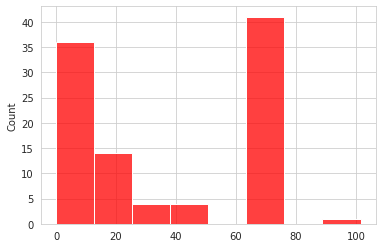

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(errores[0], kde = False, color ='red')

## Errores para elitismo individual

<AxesSubplot:ylabel='Count'>

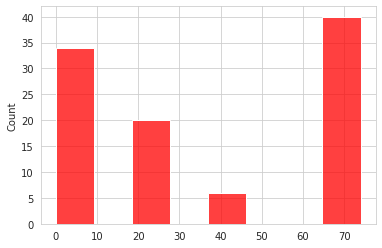

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(errores[1], kde = False, color ='red')

## Errores para elitismo porcentual

<AxesSubplot:ylabel='Count'>

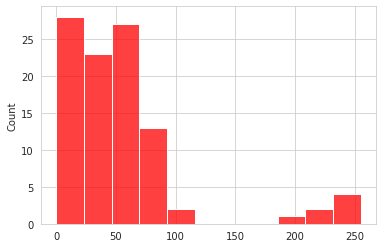

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(errores[2], kde = False, color ='red')

## Errores sin elitismo


<AxesSubplot:ylabel='Count'>

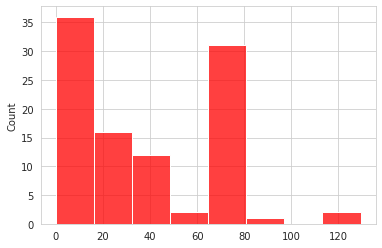

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(errores[3], kde = False, color ='red')

## Errores para todos

In [ ]:
df_errores = pd.DataFrame(np.transpose((np.asarray(errores))), columns = elitismo)

# [rastrigin, rastrigin, beale, eggholder]
df_errores_rastrigin2 = pd.DataFrame(np.transpose((np.asarray(err[0]))), columns = elitismo)
df_errores_rastrigin5 = pd.DataFrame(np.transpose((np.asarray(err[1]))), columns = elitismo)
df_errores_beale = pd.DataFrame(np.transpose((np.asarray(err[2]))), columns = elitismo)
df_errores_eggholder = pd.DataFrame(np.transpose((np.asarray(err[3]))), columns = elitismo)

In [ ]:
df_errores

,total,individual,percentage,None
0,65.955355,2.725894,43.398902,65.955465
1,24.356151,65.074106,4.852618,7.444608
2,2.752810,65.061809,65.061809,25.086958
3,43.398902,65.955355,73.959911,9.546044
4,2.725894,65.061809,2.723228,65.061809
...,...,...,...,...
95,70.692962,3.801682,73.959911,65.061809
96,65.955355,0.114828,65.089682,65.085693
97,24.302850,0.114828,43.429445,10.651142
98,43.398902,2.723343,66.037462,63.168597


<AxesSubplot:ylabel='Density'>

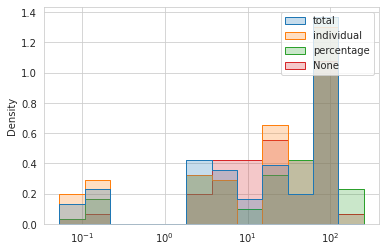

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(df_errores,  stat="density", common_norm=False, element="step", log_scale=True)

In [ ]:
# [rastrigin, rastrigin, beale, eggholder]
df_errores_rastrigin2 = pd.DataFrame(np.transpose((np.asarray(err[0]))), columns = elitismo)
df_errores_rastrigin5 = pd.DataFrame(np.transpose((np.asarray(err[1]))), columns = elitismo)
df_errores_beale = pd.DataFrame(np.transpose((np.asarray(err[2]))), columns = elitismo)
df_errores_eggholder = pd.DataFrame(np.transpose((np.asarray(err[3]))), columns = elitismo)

[Text(0.5, 1.0, 'Rastrigin n = 2')]

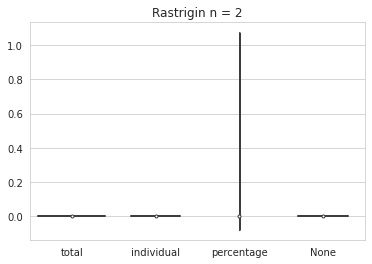

In [ ]:
sns.violinplot(data = df_errores_rastrigin2 ).set(title='Rastrigin n = 2')


[Text(0.5, 1.0, 'Rastrigin n = 5')]

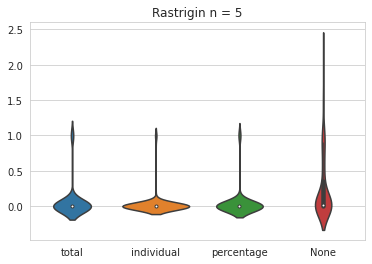

In [ ]:
sns.violinplot(data = df_errores_rastrigin5 ).set(title='Rastrigin n = 5')


[Text(0.5, 1.0, 'Beale')]

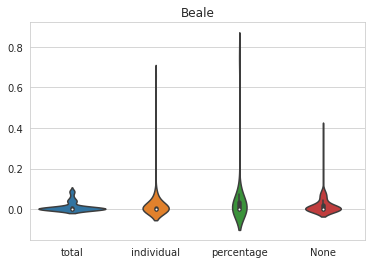

In [ ]:
sns.violinplot(data = df_errores_beale ).set(title='Beale')


[Text(0.5, 1.0, 'Eggholder')]

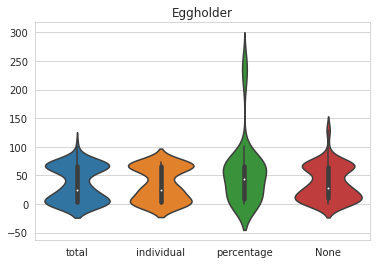

In [ ]:
sns.violinplot(data = df_errores_eggholder).set(title='Eggholder')

<AxesSubplot:ylabel='Density'>

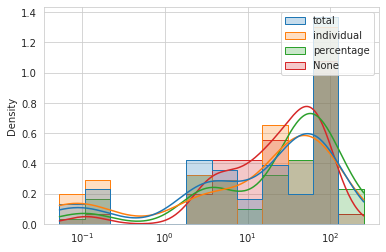

In [ ]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.histplot(df_errores_eggholder,  stat="density", common_norm=False, element="step", log_scale=True,  kde=True)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


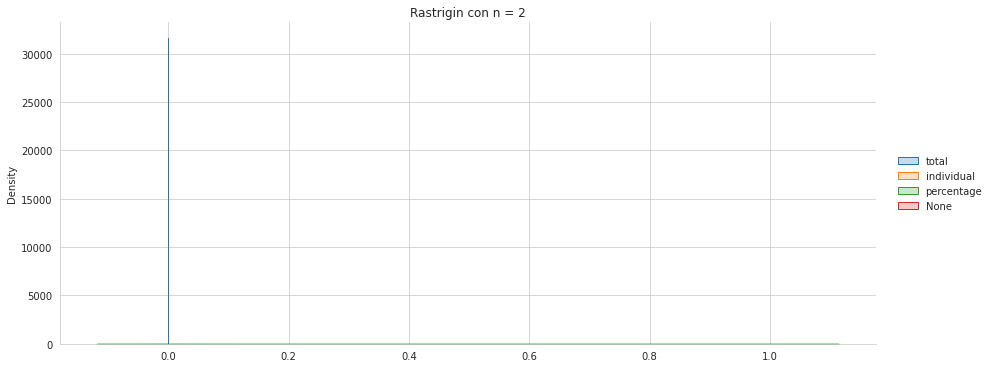

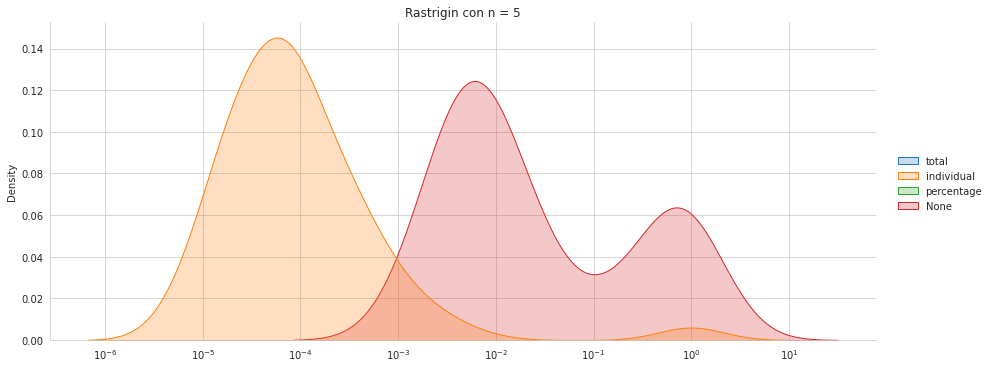

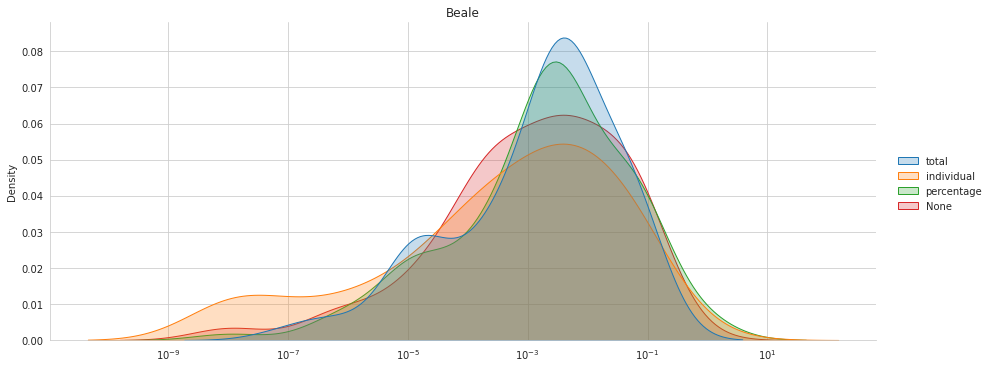

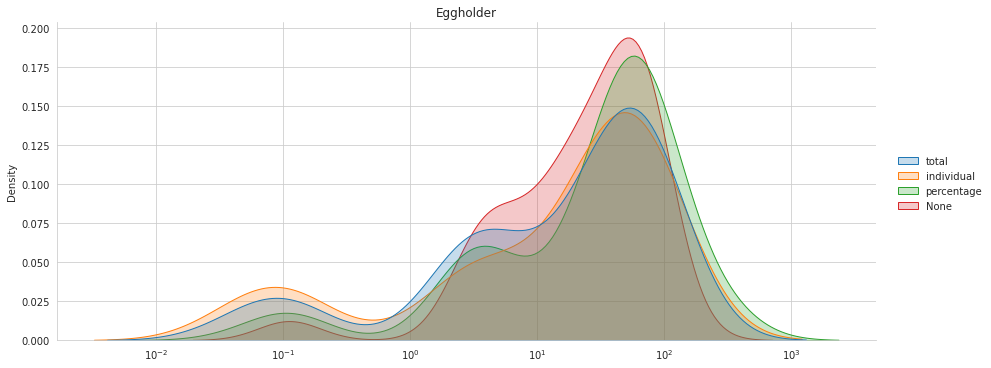

In [ ]:
sns.displot(df_errores_rastrigin2, kind="kde", fill=True, aspect = 2.5).set(title='Rastrigin con n = 2')
sns.displot(df_errores_rastrigin5, kind="kde", fill=True, log_scale=True, aspect = 2.5, ).set(title='Rastrigin con n = 5')
sns.displot(df_errores_beale, kind="kde", fill=True, log_scale=True, aspect = 2.5).set(title='Beale')
sns.displot(df_errores_eggholder, kind="kde", fill=True, log_scale=True, aspect  = 2.5).set(title='Eggholder')

In [ ]:
print("Promedio y desvuación estandar para función beale")
print(df_errores_beale.mean())
print(df_errores_beale.std())

Promedio y desvuación estandar para función beale
total         0.013855
individual    0.018553
percentage    0.037863
None          0.019190
dtype: float64
total         0.024158
individual    0.068144
percentage    0.128184
None          0.045437
dtype: float64


In [ ]:
print("Promedio y desvuación estandar para función rastrigin2")
print(df_errores_rastrigin2.mean())
print(df_errores_rastrigin2.std())

Promedio y desvuación estandar para función rastrigin2
total         0.000007
individual    0.000006
percentage    0.009958
None          0.000007
dtype: float64
total         0.000004
individual    0.000005
percentage    0.099521
None          0.000005
dtype: float64


In [ ]:
print("Promedio y desvuación estandar para función rastrigin5")
print(df_errores_rastrigin5.mean())
print(df_errores_rastrigin5.std())

Promedio y desvuación estandar para función rastrigin5
total         0.060212
individual    0.020146
percentage    0.040043
None          0.241512
dtype: float64
total         0.238312
individual    0.139969
percentage    0.197094
None          0.422809
dtype: float64


In [ ]:
print("Promedio y desvuación estandar para función eggholder")
print(df_errores_eggholder.mean())
print(df_errores_eggholder.std())

Promedio y desvuación estandar para función eggholder
total         35.575317
individual    35.129243
percentage    54.200696
None          36.582988
dtype: float64
total         30.054149
individual    28.786432
percentage    56.996896
None          29.707689
dtype: float64
